In [1]:
%pip install swig -q
%pip install -q -U gymnasium[box2d]
%pip install --upgrade ipykernel -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.4 which is incompatible.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 25.1.2 which is incompatible.


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.distributions.categorical import Categorical

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [4]:
from dataclasses import dataclass

In [5]:
"""Example Usage
e = EpisodeTrajectory([], [], [], [], [], [], [], [], [])
e.append(np.array([1]), 1, 0.5, 2, np.array([1]), 0.9, False)
"""
@dataclass
class EpisodeTrajectory:
    states: list              # (ep_len, state_size) eg(400, 96)
    actions: list             # (ep_len,) eg(400,)
    action_log_probs: list    # (ep_len,) eg(400,)
    rewards: list             # (ep_len,) eg(400,)
    next_states: list         # (ep_len, state_size) eg(400, 96)
    value_of_states: list     # (ep_len,) eg(400,)
    dones: list               # (ep_len,) eg(400,)
    returns: list             # (ep_len,) eg(400,)
    gaes: list                # (ep_len,) eg(400,)

    def append(self, state: np.array, action: int, action_log_porb: float,
               reward: int, next_state: np.array, value_of_state: float, done: bool):
        self.states.append(state)
        self.actions.append(action)
        self.action_log_probs.append(action_log_porb)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.value_of_states.append(value_of_state)
        self.dones.append(done)

In [41]:
class FFNN(nn.Module):
    def __init__(self, input_size, n_outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [42]:
class PPOAgent:
    def __init__(self, actor: FFNN, critic: FFNN, hparams: dict):
        self.actor = actor
        self.critic = critic
        self.critic_loss_fn = nn.MSELoss()

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=hparams['actor_lr'], eps=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=hparams['critic_lr'], eps=1e-5)

        self.gamma = hparams['gamma']       # Discount factor
        self.lambda_ = hparams['lambda']    # Decay factor when calculating GAE
        self.batch_size = hparams['batch_size']
        self.n_epochs = hparams['n_epochs']
        self.epsilon = hparams['epsilon']
        self.target_kl_div = hparams['target_kl_div']
        self.entropy_coeff = hparams['entropy_coeff']
        self.max_grad_norm = hparams['max_grad_norm']

    def update_lr(self, lr_decay: float) -> None:
        new_actor_lr = hparams['actor_lr'] * lr_decay
        new_critic_lr = hparams['critic_lr'] * lr_decay
        self.actor_optimizer.param_groups[0]["lr"] = new_actor_lr
        self.critic_optimizer.param_groups[0]["lr"] = new_critic_lr

    def calculate_disconted_returns(self, rewards: list) -> np.ndarray:
        """Given a list of rewards at each timestep of episode, it calculates
        the return from each timestep
        """
        discounted = np.array(rewards, dtype=float)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += self.gamma * discounted[step + 1]
        return discounted

    def calculate_generalized_advantage_estimates(self, rewards: list, values: list) -> np.ndarray:
        """Given a list of reewards, and values for each timestep,
        returns the Generarlized Estimate Advantage:
        A_t = sigma{l=0, inf} (γλ)^l δ_(t+l)
        A_t^λ = r_t + γ * V(s_{t+1}) - V(s_t) + λ * A_{t+1}^λ

        Eg: calculate_generalized_advantage_estimates(
            [7, 3, 2, 2], [10, 5, 1, 1]) -> array([3.22 , 1.59, 2.87, 1.00])
        """
        next_values = np.concatenate([values[1:], [0]])
        td_errors = [(r + self.gamma * next_val) - val for r, val, next_val in zip(rewards, values, next_values)]

        gaes = [td_errors[-1]]
        for i in reversed(range(len(td_errors)-1)):
            gaes.append(td_errors[i] + (self.lambda_ * self.gamma * gaes[-1]))

        return np.array(gaes[::-1])

    def select_action(self, state: np.ndarray) -> tuple:
        """Returns action (int) and its log probability(float)"""
        tensor_state = torch.from_numpy(state).float()
        self.actor.eval()
        with torch.no_grad():
            logits = self.actor(tensor_state)

        actions_distr = Categorical(logits=logits)
        action = actions_distr.sample()
        action_log_prob = actions_distr.log_prob(action)

        return action.item(), action_log_prob.item()

    def compute_value(self, state: np.ndarray) -> float:
        """Returns the value of the state by calling the critic"""
        tensor_state = torch.from_numpy(state).float()
        self.critic.eval()
        with torch.no_grad():
            value = self.critic(tensor_state)

        return value.item()

    def critic_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of critic training"""
        self.critic.train()
        # 1) Calculate returns
        # returns = self.calculate_disconted_returns(trajectory.rewards)                  # shape = (episode_length,)
        returns = np.array(trajectory.returns)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_states = torch.from_numpy(np.array(trajectory.states)[mb_indices]).float()  # shape = (batch_size, state_size)
                mb_returns = torch.from_numpy(returns[mb_indices]).float().unsqueeze(1)        # shape = (batch_size, 1)

                mb_predicted_returns = self.critic(mb_states)                               # shape = (batch_size, 1)

                # 4) Compute loss
                loss = self.critic_loss_fn(mb_returns, mb_predicted_returns)                # shape = float tensor

                # 5) Backpropagate the gradients
                self.critic_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.critic_optimizer.step()        # update weights

    def actor_training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does n_epochs of actor training"""
        self.actor.train()
        # 1) Calculate the Generalized Advantage Estimates
        # gaes = self.calculate_generalized_advantage_estimates(                  # shape = (episode_length,)
        #     trajectory.rewards, trajectory.value_of_states)
        gaes = np.array(trajectory.gaes)                                        # shape = (episode_length,)

        # 2) Do n_epochs of training
        for _ in range(self.n_epochs):
            train_size = len(trajectory.rewards)
            indices = np.random.randint(train_size, size=train_size)

            for start in range(0, train_size, self.batch_size):
                end = start + self.batch_size
                mb_indices = indices[start:end]

                # 3) Sample a mini-batch of data
                mb_states = torch.from_numpy(np.array(trajectory.states)[mb_indices]).float()    # shape = (batch_size, state_size)
                mb_actions = torch.from_numpy(np.array(trajectory.actions)[mb_indices])          # shape = (batch_size,)
                mb_action_log_probs = torch.from_numpy(np.array(trajectory.action_log_probs)[mb_indices])  # shape = (batch_size,)
                mb_gaes = torch.from_numpy(gaes[mb_indices]).float()                             # shape = (batch_size,)
                # mb_gaes = (mb_gaes - mb_gaes.mean()) / (mb_gaes.std() + 1e-10)

                # 4) Calculate the new_log_probs
                new_logits = self.actor(mb_states)                                  # shape = (batch_size, 6)
                new_action_distr = Categorical(logits=new_logits)
                new_log_probs = new_action_distr.log_prob(mb_actions)               # shape = (batch_size,)
                entropy = new_action_distr.entropy()                                # shape = (batch_size,)

                # 5) Calculate the ratio
                policy_ratio = torch.exp(new_log_probs - mb_action_log_probs)       # shape = (batch_size,)
                clipped_ratio = policy_ratio.clamp(1-self.epsilon, 1+self.epsilon)

                # 6) Calculate the unclipped and clipped_loss, and then loss
                unclipped_loss = policy_ratio * mb_gaes                             # shape = (batch_size,)
                clipped_loss = clipped_ratio * mb_gaes                              # shape = (batch_size,)
                loss = (-torch.min(unclipped_loss, clipped_loss)).mean()            # shape = float tensor
                entropy_loss = entropy.mean()                                       # shape = float tensor
                loss = loss - (self.entropy_coeff * entropy_loss)                   # shape = float tensor

                # 7) Backpropagate the gradients
                self.actor_optimizer.zero_grad()
                loss.backward()                     # backward pass
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.actor_optimizer.step()         # update weights

            # 8) Stop if policy is changing too much
            kl_div = (mb_action_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def training_step(self, trajectory: EpisodeTrajectory) -> None:
        """Does an actor, and a critic training step"""
        self.actor_training_step(trajectory)
        self.critic_training_step(trajectory)


In [43]:
def get_episode_trajectory(n_episodes: int, env, agent: PPOAgent):
    """Plays n_episodes and returns the trajectory, which is a tuple of
    (states, actions, action_log_probs, rewards, next_states, value_of_states, dones)
    Each of these elements is of length: episode_lenght,
        state: (ep_len, state_size) eg(400, 96)
        action: (ep_len,) eg(400,)
        action_log_prob: (ep_len,) eg(400,)
        reward: (ep_len,) eg(400,)
        next_state: (ep_len, state_size) eg(400, 96)
        value_of_state: (ep_len,) eg(400,)
        dones: (ep_len,) eg(400,)
    """
    agent_trajectory = EpisodeTrajectory([], [], [], [], [], [], [], [], [])
    episode_rewards = []
    # state = env.reset()

    for episode_idx in range(n_episodes):
        episode_reward = 0
        state, _ = env.reset()

        for step in range(1000):
            # 1) Select actions
            action, action_log_prob = agent.select_action(state)

            # 2) Take actions on env
            next_state, common_reward, done, truncated, info = env.step(action)

            # 3) Record transition data
            value = agent.compute_value(state)

            agent_trajectory.append(
                state, action, action_log_prob, common_reward, next_state, value, done)

            # 5a) Record rewards
            episode_reward += common_reward
            # 5b) Update states
            state = next_state

            if done or truncated:
                break

        returns_at_each_episode_timestep = list(agent.calculate_disconted_returns(agent_trajectory.rewards[-step-1:]))
        agent_trajectory.returns += returns_at_each_episode_timestep
        gaes_at_each_episode_timestep = list(
            agent.calculate_generalized_advantage_estimates(
                agent_trajectory.rewards[-step-1:], agent_trajectory.value_of_states[-step-1:]))
        agent_trajectory.gaes += gaes_at_each_episode_timestep

        episode_rewards.append(episode_reward)

    return agent_trajectory, episode_rewards

In [48]:
hparams = {
    'gamma': 0.99,
    'lambda': 0.97,
    'batch_size': 64,
    'n_epochs': 20,
    'actor_lr': 4e-4,
    'critic_lr': 4e-4,
    'epsilon': 0.2,
    'target_kl_div': 0.02,
    'entropy_coeff': 0.01,
    'max_grad_norm': 0.5,
    'max_iters': 400,
}

In [49]:
def train_ppo_agent(run_name: str):
    # Set Up
    # env_ = gym.make('CartPole-v0')
    env_ = gym.make('LunarLander-v2')
    input_shape = env_.observation_space.shape
    n_outputs = env_.action_space.n

    actor = FFNN(input_shape[0], n_outputs)
    critic = FFNN(input_shape[0], 1)
    agent = PPOAgent(actor, critic, hparams)

    num_iters = 300
    n_episodes_per_trajectory = 5
    episode_idx = 0

    # Do training
    total_reward_per_episode = []
    average_episode_reward_over_last_100 = []

    for iter_idx in range(num_iters):
        # 1) Play an episode
        agent_trajectory, episode_rewards = get_episode_trajectory(
            n_episodes_per_trajectory, env_, agent)

        # 2) Update learning rate
        lr_decay = 1.0 - ((iter_idx) / hparams['max_iters'])
        agent.update_lr(lr_decay)

        # 3) Do training step
        agent.training_step(agent_trajectory)

        # 4) Record results and log info
        total_reward_per_episode += episode_rewards
        if episode_idx % 100 == 0:
            average_episode_reward_over_last_100.append(np.mean(total_reward_per_episode[-100:]))

        # 5) Print out debug
        for episode_reward in episode_rewards:
            print(f"\rEpisode: {episode_idx} " +
                  f"episode_reward: {episode_reward} "
                  f"average_episode_reward_over_last_100: {average_episode_reward_over_last_100[-1]}", end="")
            episode_idx += 1

        # 6) Check for convergence
        min_reward = 190
        if (average_episode_reward_over_last_100[-1] > min_reward):
            print(f"\nConverged: Achieved an average reward >{min_reward} on episode {episode_idx}, iteration {iter_idx}")
            break

    return total_reward_per_episode, agent

In [50]:
run_name = "run3.3"

In [51]:
total_reward_per_episode, agent = train_ppo_agent(run_name)

Episode: 804 episode_reward: 292.31974877481696 average_episode_reward_over_last_100: 190.83550444727072
Converged: Achieved an average reward >190 on episode 805, iteration 160


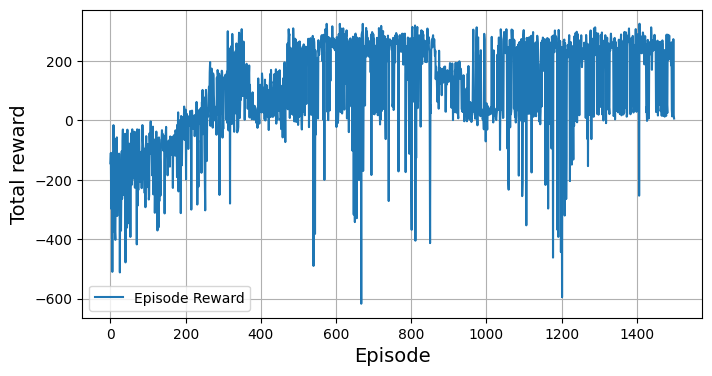

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{run_name}_during_training.png")
plt.show()

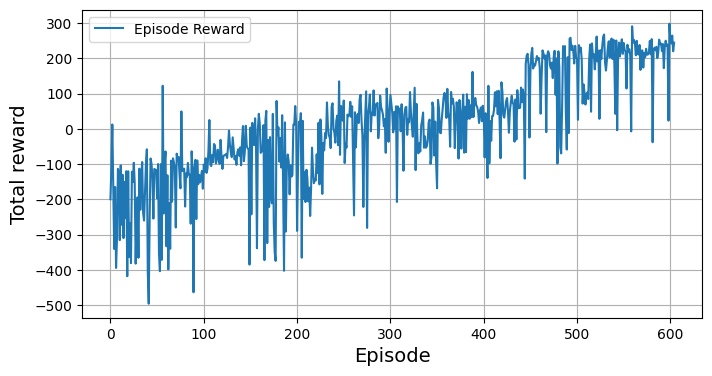

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(total_reward_per_episode, label="Episode Reward")
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total reward", fontsize=14)
plt.grid(True)
plt.legend()  # Add legend to distinguish the lines
plt.savefig(f"{run_name}_during_training.png")
plt.show()